In [1]:
import torch
from torch import nn

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import trange

import model
from data import seq_data, grid_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import ActivationsAnimation
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

device = torch.device("cpu")


GPU not available, CPU used


In [2]:
## Generate data
symbols = [0, 1]
encoding = OneHot(symbols)
xor_problem = lambda seq: np.sum(seq) % 2
par_3_problem = lambda seq: int(np.sum(seq) % 3 == 2)
problem = xor_problem

N = 50

train_datasets = [
    seq_data(device, problem, encoding, seq_len=1, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=2, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=3, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=4, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=5, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=6, n_datapoints=N),
    # seq_data(device, problem, encoding, seq_len=7, n_datapoints=30),
]

# train_datasets = [
#     seq_data(device, problem, encoding, seq_len=1, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=5, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=7, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=9, n_datapoints=3),
#     seq_data(device, problem, encoding, seq_len=11, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=12, n_datapoints=2),
# ]

val_dataset = [seq_data(device, problem, encoding, n_datapoints=50, seq_len=10)]
tracked_datasets = val_dataset + train_datasets


grid = grid_data(device, dim=2, output_dim=2, n=20, bounds=(-1, 1))


In [3]:
## Instantiate model
model = model.Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=100,
    n_layers=1,
    device=device,
    init_std=0.1,
    # output_noise=0.01,
)

## TODO: Try starting with large weights


In [4]:
## Train

# Define hyperparameters
n_epochs = 1000
lr = 0.003

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][-1], initial=initial_hidden
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}


In [5]:
# Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=1000
)


Training: 100%|██████████| 1000/1000 [01:09<00:00, 14.40steps/s, train_loss=0.00015, val_loss=0.00010]


Computing automata: 100%|██████████| 1000/1000 [00:04<00:00, 210.46it/s]


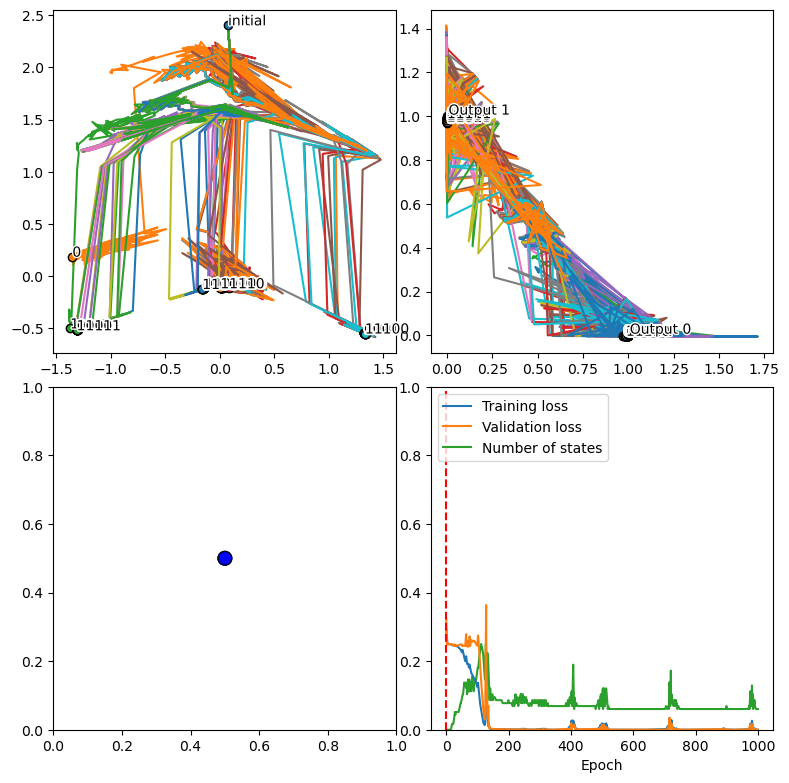

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='39%'), max=999), Output())…

In [6]:
## Show evolution of hidden states
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
query += "and (Dataset != 0)"
query += "and (Dataset <= 5)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

std = np.linalg.norm(data_hid.std())


automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.05 * std
)

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
# mergers = np.array(automaton_history.get_state_changes()[0])
# splits = np.array(automaton_history.get_state_changes()[1])
n_states = np.array([len(automaton.states) for automaton in automaton_history])

animation = SliderAnimation(
    [
        ActivationsAnimation(data_hid, transform="PCA", n_labels=0),
        ActivationsAnimation(
            data_output, transform="none", n_labels=0, encoding=encoding
        ),
        AutomatonAnimation(automaton_history),
        EpochAnimation(
            graphs={"Training loss": train_loss,"Validation loss": val_loss,},
            unitless_graphs={"Number of states": n_states},
            y_bounds=(0, 1),
        ),
    ],
    parameters=list(set(data_hid.index.get_level_values("Epoch"))),
    fig_size=4,
)


# TODO Plot map A(h)
# TODO Plot pairwise distances


In [15]:
animation.to_gif("animation", step_size=math.floor(n_epochs/500))


TypeError: 'numpy.float64' object cannot be interpreted as an integer

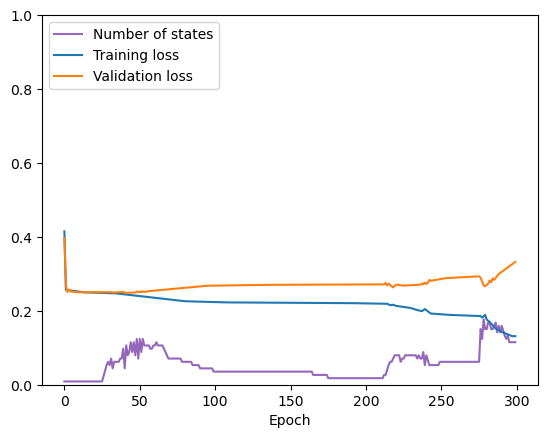

In [ ]:
## Plot training and validation loss during training
epoch = 3
scale = 1
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
max_n_states = np.sum([len(dataset) for dataset in train_datasets]) + 1
mergers = np.array(automaton_history.get_state_changes()[0]) * scale / max_n_states
splits = np.array(automaton_history.get_state_changes()[1]) * scale / max_n_states
n_states = (
    np.array([len(automaton.states) for automaton in automaton_history])
    * scale
    / max_n_states
)
d_n_states = n_states[1:] - n_states[:-1]
# plt.plot(mergers, label="State mergers", alpha=0.5, color="tab:red")
# plt.plot(splits, label="State splits", alpha=0.5, color="tab:green")
plt.plot(n_states, label="Number of states", alpha=1, color="tab:purple")
# plt.plot(mergers + splits, label="Number of states changes", alpha=1, color="tab:brown")
plt.plot(train_loss, label="Training loss", color="tab:blue")
plt.plot(val_loss, label="Validation loss", color="tab:orange")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
# plt.xlim(1200, 1300)
plt.ylim(0, scale)
plt.show()


100%|██████████| 100/100 [00:00<00:00, 172.09it/s]


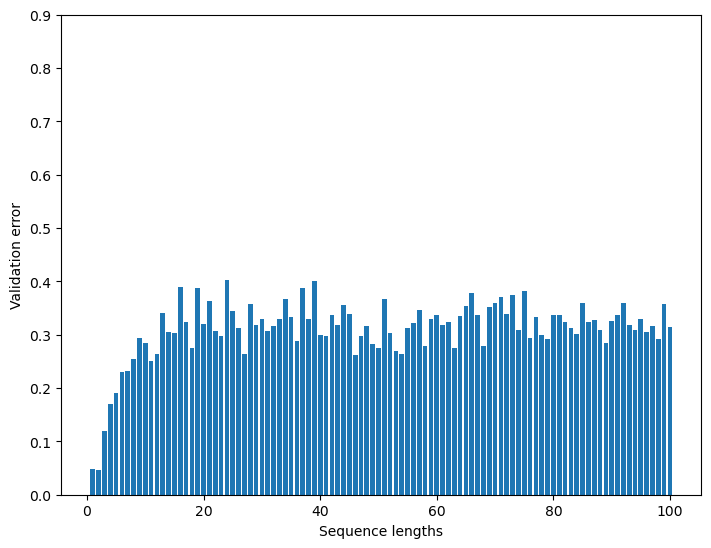

In [ ]:
## Plot error per sequence length
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()


In [ ]:
def predict(model, sequence):
    input = torch.from_numpy(np.array([encoding(sequence)], dtype=np.float32)).to(
        device
    )
    out, hidden = model(input)
    prediction = out.cpu().detach().numpy()
    return prediction


test_seq = [0, 0, 0, 1, 0, 0, 0]
print(f"Prediction: {predict(model, test_seq)}, True output: {problem(test_seq)}")


Prediction: [[0.36983946 0.6283234 ]], True output: 1
